In [1]:
import tensorflow as tf 
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
nifty = pd.read_csv("NIFTY_50_5_Year_His_Data.csv")
nyse = pd.read_csv("NYSE_5_Year_His_Data.csv")

df_nifty = pd.DataFrame(nifty)
df_nyse = pd.DataFrame(nyse)

df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])
df_nyse['Date'] = pd.to_datetime(df_nyse['Date'])

df_nifty.set_index('Date', inplace=True)
df_nyse.set_index('Date', inplace=True)

common_dates = df_nifty.index.intersection(df_nyse.index)
df_nifty_common = df_nifty.loc[common_dates]
df_nyse_common = df_nyse.loc[common_dates]

df_nifty_common['return'] = df_nifty_common['Close'].pct_change()
df_nyse_common['return'] = df_nyse_common['Close'].pct_change()

# Drop NaNs from pct_change
returns_nifty = df_nifty_common['return'].dropna()
returns_nyse = df_nyse_common['return'].dropna()

# Align shapes
min_len = min(len(returns_nifty), len(returns_nyse))
returns_nifty = returns_nifty[-min_len:]
returns_nyse = returns_nyse[-min_len:]

# Build datasets
lookback = 30
x_data = []
y_data = []
for i in range(lookback, len(returns_nyse)):
    x_data.append(returns_nyse.iloc[i - lookback:i].values)
    y_data.append([returns_nifty.iloc[i]])

x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

# Train-test split
split = int(0.8 * len(x_data))
x_train, x_val = x_data[:split], x_data[split:]
y_train, y_val = y_data[:split], y_data[split:]


C:\Users\kumar\AppData\Local\Temp\ipykernel_20592\3331651453.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])


In [3]:
lookback = 30
X, Y = [], []

returns_nyse = df_nyse_common['return'].values
returns_nifty = df_nifty_common['return'].values

for i in range(lookback, len(returns_nyse) - 1):
    X.append(returns_nyse[i-lookback:i])
    Y.append(returns_nifty[i+1])

X = np.array(X)
Y = np.array(Y).reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

In [4]:
# Hyperparameters
T = 1000
beta_start = 1e-4
beta_end = 0.02
embedding_dim = 32
input_dim = 30

In [5]:
# Noise Schedule
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars_np = np.cumprod(alphas).astype(np.float32)
alpha_bars = tf.convert_to_tensor(alpha_bars_np, dtype=tf.float32)


In [6]:
def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = tf.exp(
        -tf.math.log(10000.0) * tf.range(0, half, dtype=tf.float32) / (half - 1)
    )
    angles = tf.cast(timesteps, tf.float32)[:, None] * freqs[None, :]
    emb = tf.concat([tf.sin(angles), tf.cos(angles)], axis=1)
    return emb

In [7]:
# Simple MLP Denoising Network
def get_denoise_model1():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    x = layers.Concatenate()([y_t_input, t_input, nyse_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)

    return Model([y_t_input, t_input, nyse_input], out)

In [8]:
# Feedforward Residual Network
def get_denoise_model2():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    nyse_proj = layers.Dense(64, activation='relu')(nyse_input)
    x = layers.Concatenate()([y_t_input, t_input, nyse_proj]) 

    # Project to residual dimension
    x_proj = layers.Dense(128)(x)  # match residual block size

    # Residual Block 1
    h = layers.Dense(128, activation='relu')(x_proj)
    h = layers.Dropout(0.1)(h)
    h = layers.Dense(128)(h)
    x = layers.Add()([x_proj, h])
    x = layers.Activation('relu')(x)

    # Residual Block 2
    h = layers.Dense(128, activation='relu')(x)
    h = layers.Dropout(0.1)(h)
    h = layers.Dense(128)(h)
    x = layers.Add()([x, h])
    x = layers.Activation('relu')(x)
    
    out = layers.Dense(1)(x)

    return Model([y_t_input,t_input,nyse_input],out)

In [9]:
# Residual LSTM Denoising Model
def get_denoise_model3():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    t_emb = layers.Dense(32, activation='relu')(t_input)
    x = layers.Concatenate()([t_emb, nyse_input])
    x = layers.Reshape((1, 62))(x)

    lstm_out = layers.LSTM(64, return_sequences=True)(x)
    skip = lstm_out  # Save for residual

    lstm_out = layers.LSTM(64, return_sequences=False)(lstm_out)
    x = layers.Concatenate()([lstm_out, y_t_input])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1)(x)

    return Model(inputs=[y_t_input, t_input, nyse_input], outputs=x)


In [10]:
# Self-Attention-Based Denoising Model
def get_denoise_model4():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    x = layers.Reshape((input_dim, 1))(nyse_input)
    attention = layers.MultiHeadAttention(num_heads=2, key_dim=16)
    x = attention(x, x)
    x = layers.Flatten()(x)

    x = layers.Concatenate()([x, t_input, y_t_input])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1)(x)

    return Model([y_t_input, t_input, nyse_input], x)


In [11]:
# Transformer Encoder Block
def get_denoise_model5():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    x = layers.Reshape((input_dim, 1))(nyse_input)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Concatenate()([x, y_t_input, t_input])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1)(x)

    return Model([y_t_input, t_input, nyse_input], x)


In [12]:
# Forward Pass
def q_sample(y_0,t,noise):
    a_bar = tf.gather(alpha_bars,t)
    a_bar = tf.reshape(a_bar,(-1,1))
    return tf.sqrt(a_bar)*y_0+tf.sqrt(1.-a_bar)*noise

In [13]:
#  Training Step
def train_step(model,optimizer,x_batch,y_batch):
    batch_size = tf.shape(x_batch)[0]
    t = tf.random.uniform((batch_size,),minval=0,maxval=T,dtype=tf.int32)
    t_emb = get_timestep_embedding(t.numpy(),embedding_dim)

    noise = tf.random.normal(shape=tf.shape(y_batch))
    y_t = q_sample(y_batch,t,noise)

    with tf.GradientTape() as tape:
        pred_noise = model([y_t,t_emb,x_batch],training=True)
        loss = tf.reduce_mean(tf.square(pred_noise-noise))
    
    grads = tape.gradient(loss,model.trainable_weights)
    optimizer.apply_gradients(zip(grads,model.trainable_weights))
    
    return loss

In [14]:
#  DDIM Sampling
def ddim_sample(model,x_cond,eta=0.0):
    batch_size = tf.shape(x_cond)[0]
    y_t = tf.random.normal((batch_size, 1))

    for i in reversed(range(1, T)):
        batch_size = tf.shape(x_cond)[0]
        t = tf.fill([batch_size], i)  # shape (234,)
        t_emb = get_timestep_embedding(t, embedding_dim)
        # t_emb = tf.repeat(t_emb, repeats=batch_size, axis=0)

        pred_noise = model([y_t, t_emb, x_cond], training=False)

        a_bar = tf.gather(alpha_bars, t)
        a_bar_prev = tf.gather(alpha_bars, t-1)

        a_bar = tf.reshape(a_bar, (-1, 1))
        a_bar_prev = tf.reshape(a_bar_prev, (-1, 1))

        y_0 = (y_t - tf.sqrt(1. - a_bar) * pred_noise) / tf.sqrt(a_bar)
        y_t = tf.sqrt(a_bar_prev) * y_0 + tf.sqrt(1. - a_bar_prev) * pred_noise

    return y_0

In [15]:
#  Training 

model1 = get_denoise_model1()
model2 = get_denoise_model2()
model3 = get_denoise_model3()
model4 = get_denoise_model4()
model5 = get_denoise_model5()
optimizer1 = Adam(1e-3)
optimizer2 = Adam(1e-3)
optimizer3 = Adam(1e-3)
optimizer4 = Adam(1e-3)
optimizer5 = Adam(1e-3)

nyse_scaler = StandardScaler()
nse_scaler = StandardScaler()

x_train = nyse_scaler.fit_transform(x_train)
x_val = nyse_scaler.transform(x_val)

y_train = nse_scaler.fit_transform(y_train)
y_val = nse_scaler.transform(y_val)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(64)
x_val_batch = tf.convert_to_tensor(x_val, dtype=tf.float32)

num_epochs = 100
print("Training Model1")
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model1, optimizer1, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

Training Model1
Epoch 1: Loss = 0.9746
Epoch 2: Loss = 0.9052
Epoch 3: Loss = 0.2825
Epoch 4: Loss = 0.4983
Epoch 5: Loss = 0.5942
Epoch 6: Loss = 0.2922
Epoch 7: Loss = 0.1797
Epoch 8: Loss = 0.3691
Epoch 9: Loss = 0.4362
Epoch 10: Loss = 0.4981
Epoch 11: Loss = 0.1378
Epoch 12: Loss = 0.3810
Epoch 13: Loss = 0.8807
Epoch 14: Loss = 0.2457
Epoch 15: Loss = 0.4095
Epoch 16: Loss = 0.2875
Epoch 17: Loss = 0.1733
Epoch 18: Loss = 0.4358
Epoch 19: Loss = 0.2342
Epoch 20: Loss = 0.1703
Epoch 21: Loss = 0.1636
Epoch 22: Loss = 0.1479
Epoch 23: Loss = 0.2391
Epoch 24: Loss = 0.2761
Epoch 25: Loss = 0.4135
Epoch 26: Loss = 0.2511
Epoch 27: Loss = 0.3517
Epoch 28: Loss = 0.2202
Epoch 29: Loss = 0.1247
Epoch 30: Loss = 0.3473
Epoch 31: Loss = 0.2293
Epoch 32: Loss = 0.2779
Epoch 33: Loss = 0.3122
Epoch 34: Loss = 0.1082
Epoch 35: Loss = 0.2230
Epoch 36: Loss = 0.2736
Epoch 37: Loss = 0.3644
Epoch 38: Loss = 0.2116
Epoch 39: Loss = 0.2175
Epoch 40: Loss = 0.2368
Epoch 41: Loss = 0.2924
Epoch 42:

Model 1 -> MSE: 0.000474, MAE: 0.012214
Drift-Adjusted MSE: 0.000474, MAE: 0.012273
Drift-Adjusted Directional Accuracy: 53.42%


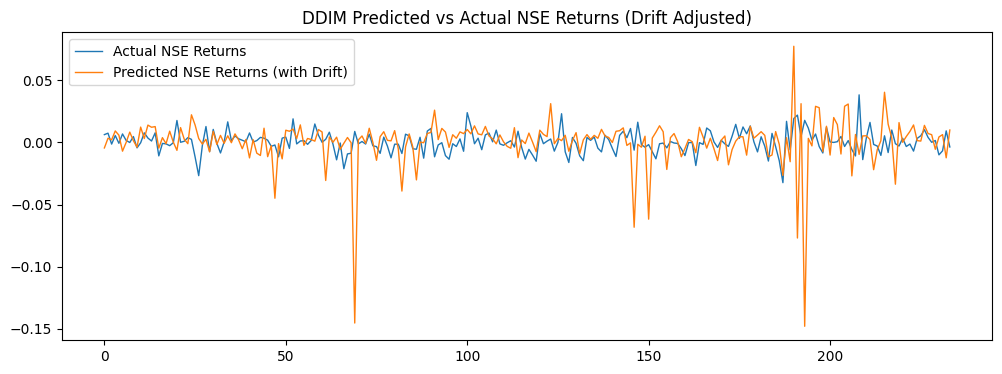

In [16]:
# Evaluation 
preds = ddim_sample(model1, x_val_batch)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 1 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()

In [18]:
print("Training Model2")
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model2, optimizer2, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

Training Model2
Epoch 1: Loss = 0.4076
Epoch 2: Loss = 0.1733
Epoch 3: Loss = 0.3479
Epoch 4: Loss = 0.2742
Epoch 5: Loss = 0.5121
Epoch 6: Loss = 0.2685
Epoch 7: Loss = 0.6558
Epoch 8: Loss = 0.7909
Epoch 9: Loss = 0.1929
Epoch 10: Loss = 0.4576
Epoch 11: Loss = 0.2516
Epoch 12: Loss = 0.1403
Epoch 13: Loss = 0.4440
Epoch 14: Loss = 0.2914
Epoch 15: Loss = 0.3091
Epoch 16: Loss = 0.3285
Epoch 17: Loss = 0.2148
Epoch 18: Loss = 0.3962
Epoch 19: Loss = 0.2067
Epoch 20: Loss = 0.2370
Epoch 21: Loss = 0.2397
Epoch 22: Loss = 0.2495
Epoch 23: Loss = 0.2140
Epoch 24: Loss = 0.2916
Epoch 25: Loss = 0.3501
Epoch 26: Loss = 0.2142
Epoch 27: Loss = 0.1683
Epoch 28: Loss = 0.4729
Epoch 29: Loss = 0.5654
Epoch 30: Loss = 0.2844
Epoch 31: Loss = 0.1873
Epoch 32: Loss = 0.2577
Epoch 33: Loss = 0.1116
Epoch 34: Loss = 0.1550
Epoch 35: Loss = 0.3847
Epoch 36: Loss = 0.4241
Epoch 37: Loss = 0.2272
Epoch 38: Loss = 0.1196
Epoch 39: Loss = 0.4312
Epoch 40: Loss = 0.1368
Epoch 41: Loss = 0.1091
Epoch 42:

Model 2 -> MSE: 0.000156, MAE: 0.009432
Drift-Adjusted MSE: 0.000157, MAE: 0.009477
Drift-Adjusted Directional Accuracy: 55.13%


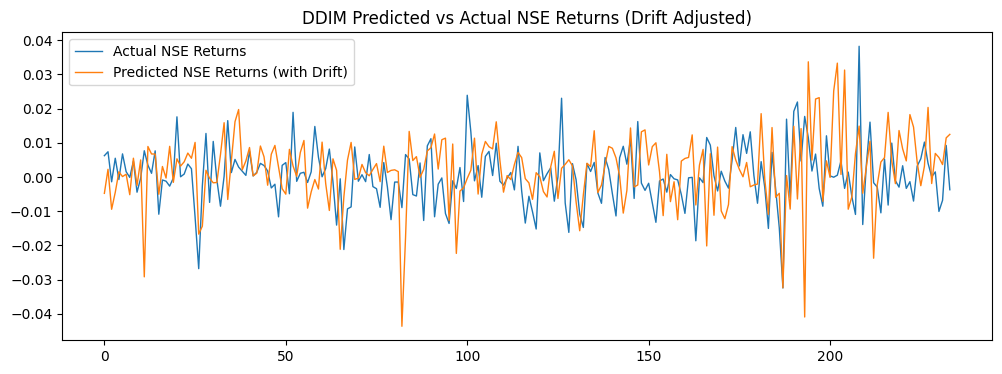

In [19]:
preds = ddim_sample(model2, x_val_batch)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 2 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()


In [21]:
print("Training Model3")
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model3, optimizer3, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

Training Model3
Epoch 1: Loss = 0.6302
Epoch 2: Loss = 0.2433
Epoch 3: Loss = 0.3360
Epoch 4: Loss = 0.1396
Epoch 5: Loss = 0.3028
Epoch 6: Loss = 0.1413
Epoch 7: Loss = 0.2879
Epoch 8: Loss = 0.3960
Epoch 9: Loss = 0.1325
Epoch 10: Loss = 0.3836
Epoch 11: Loss = 0.3805
Epoch 12: Loss = 0.1684
Epoch 13: Loss = 0.3046
Epoch 14: Loss = 0.1827
Epoch 15: Loss = 0.3170
Epoch 16: Loss = 0.0986
Epoch 17: Loss = 0.1508
Epoch 18: Loss = 0.5913
Epoch 19: Loss = 0.2517
Epoch 20: Loss = 0.4583
Epoch 21: Loss = 0.4846
Epoch 22: Loss = 0.3970
Epoch 23: Loss = 0.2073
Epoch 24: Loss = 0.1737
Epoch 25: Loss = 0.5165
Epoch 26: Loss = 0.2330
Epoch 27: Loss = 0.1222
Epoch 28: Loss = 0.2942
Epoch 29: Loss = 0.1777
Epoch 30: Loss = 0.3150
Epoch 31: Loss = 0.1798
Epoch 32: Loss = 0.2147
Epoch 33: Loss = 0.1730
Epoch 34: Loss = 0.3565
Epoch 35: Loss = 0.3499
Epoch 36: Loss = 0.2950
Epoch 37: Loss = 0.2828
Epoch 38: Loss = 0.1960
Epoch 39: Loss = 0.2990
Epoch 40: Loss = 0.2936
Epoch 41: Loss = 0.1425
Epoch 42:

Model 3 -> MSE: 0.000171, MAE: 0.008970
Drift-Adjusted MSE: 0.000171, MAE: 0.008966
Drift-Adjusted Directional Accuracy: 52.99%


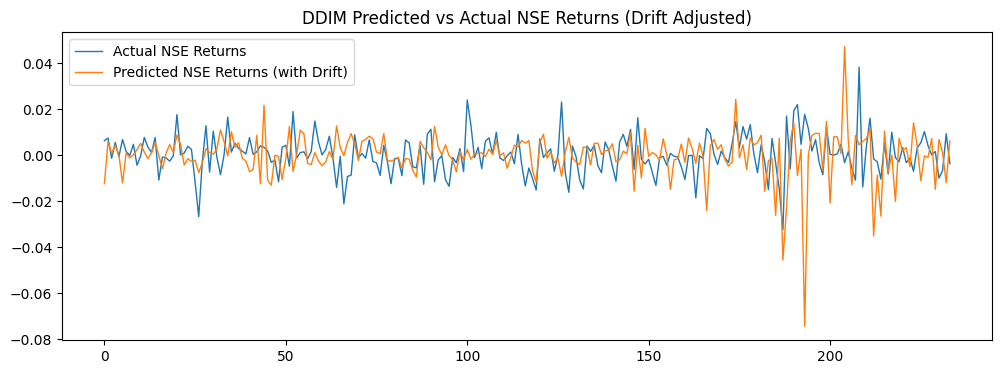

In [22]:
preds = ddim_sample(model3, x_val_batch)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 3 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()


In [23]:
print("Training Model4")
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model4, optimizer4, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

Training Model4
Epoch 1: Loss = 0.9268
Epoch 2: Loss = 0.6446
Epoch 3: Loss = 0.3679
Epoch 4: Loss = 0.5884
Epoch 5: Loss = 0.5345
Epoch 6: Loss = 0.5603
Epoch 7: Loss = 0.2307
Epoch 8: Loss = 0.1870
Epoch 9: Loss = 0.1068
Epoch 10: Loss = 0.2309
Epoch 11: Loss = 0.2384
Epoch 12: Loss = 0.2933
Epoch 13: Loss = 0.3989
Epoch 14: Loss = 0.1682
Epoch 15: Loss = 0.2781
Epoch 16: Loss = 0.0997
Epoch 17: Loss = 0.2172
Epoch 18: Loss = 0.3821
Epoch 19: Loss = 0.1622
Epoch 20: Loss = 0.4388
Epoch 21: Loss = 0.1725
Epoch 22: Loss = 0.4864
Epoch 23: Loss = 0.2070
Epoch 24: Loss = 0.2914
Epoch 25: Loss = 0.4000
Epoch 26: Loss = 0.1924
Epoch 27: Loss = 0.3409
Epoch 28: Loss = 0.7630
Epoch 29: Loss = 0.1484
Epoch 30: Loss = 0.2810
Epoch 31: Loss = 0.5075
Epoch 32: Loss = 0.2058
Epoch 33: Loss = 0.3273
Epoch 34: Loss = 0.1108
Epoch 35: Loss = 0.2222
Epoch 36: Loss = 0.1678
Epoch 37: Loss = 0.2800
Epoch 38: Loss = 0.2474
Epoch 39: Loss = 0.2012
Epoch 40: Loss = 0.3018
Epoch 41: Loss = 0.2008
Epoch 42:

Model 4 -> MSE: 0.000318, MAE: 0.011923
Drift-Adjusted MSE: 0.000319, MAE: 0.011976
Drift-Adjusted Directional Accuracy: 51.28%


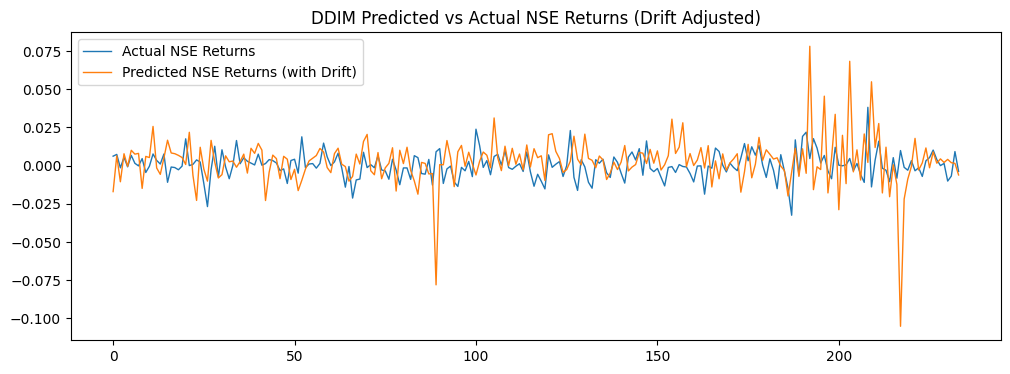

In [24]:
preds = ddim_sample(model4, x_val_batch)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 4 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()


In [25]:
print("Training Model5")
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model5, optimizer5, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

Training Model5
Epoch 1: Loss = 0.5972
Epoch 2: Loss = 0.5223
Epoch 3: Loss = 0.3365
Epoch 4: Loss = 0.7012
Epoch 5: Loss = 0.4022
Epoch 6: Loss = 0.1407
Epoch 7: Loss = 0.1926
Epoch 8: Loss = 0.4929
Epoch 9: Loss = 0.5666
Epoch 10: Loss = 0.3401
Epoch 11: Loss = 0.4205
Epoch 12: Loss = 0.4509
Epoch 13: Loss = 0.4259
Epoch 14: Loss = 0.1995
Epoch 15: Loss = 0.5235
Epoch 16: Loss = 0.3435
Epoch 17: Loss = 0.4952
Epoch 18: Loss = 0.5579
Epoch 19: Loss = 0.4574
Epoch 20: Loss = 0.5772
Epoch 21: Loss = 0.1430
Epoch 22: Loss = 0.1220
Epoch 23: Loss = 0.2458
Epoch 24: Loss = 0.3853
Epoch 25: Loss = 0.2375
Epoch 26: Loss = 0.3652
Epoch 27: Loss = 0.3506
Epoch 28: Loss = 0.5807
Epoch 29: Loss = 0.2357
Epoch 30: Loss = 0.2529
Epoch 31: Loss = 0.2714
Epoch 32: Loss = 0.2849
Epoch 33: Loss = 0.3821
Epoch 34: Loss = 0.2772
Epoch 35: Loss = 0.2380
Epoch 36: Loss = 0.2022
Epoch 37: Loss = 0.1611
Epoch 38: Loss = 0.6346
Epoch 39: Loss = 0.5482
Epoch 40: Loss = 0.1621
Epoch 41: Loss = 0.3233
Epoch 42:

Model 5 -> MSE: 0.000133, MAE: 0.008456
Drift-Adjusted MSE: 0.000133, MAE: 0.008470
Drift-Adjusted Directional Accuracy: 50.43%


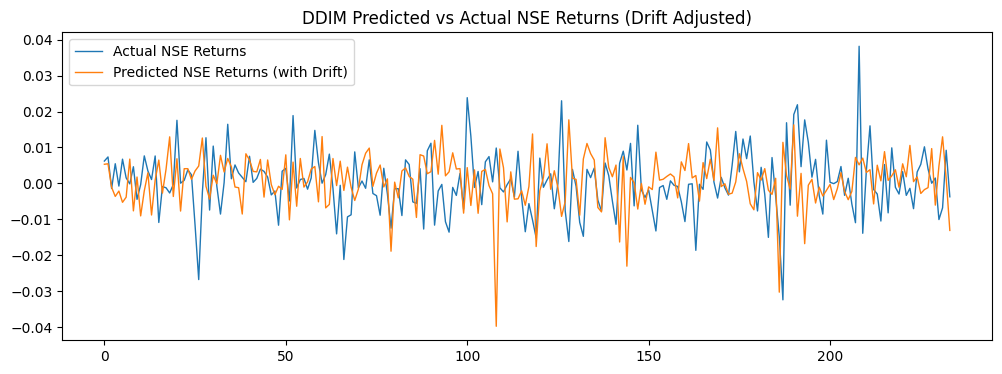

In [26]:
preds = ddim_sample(model5, x_val_batch)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 5 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()


C:\Users\kumar\AppData\Local\Temp\ipykernel_1868\1681221966.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])



Training Transformer model...

Training Residual_LSTM model...


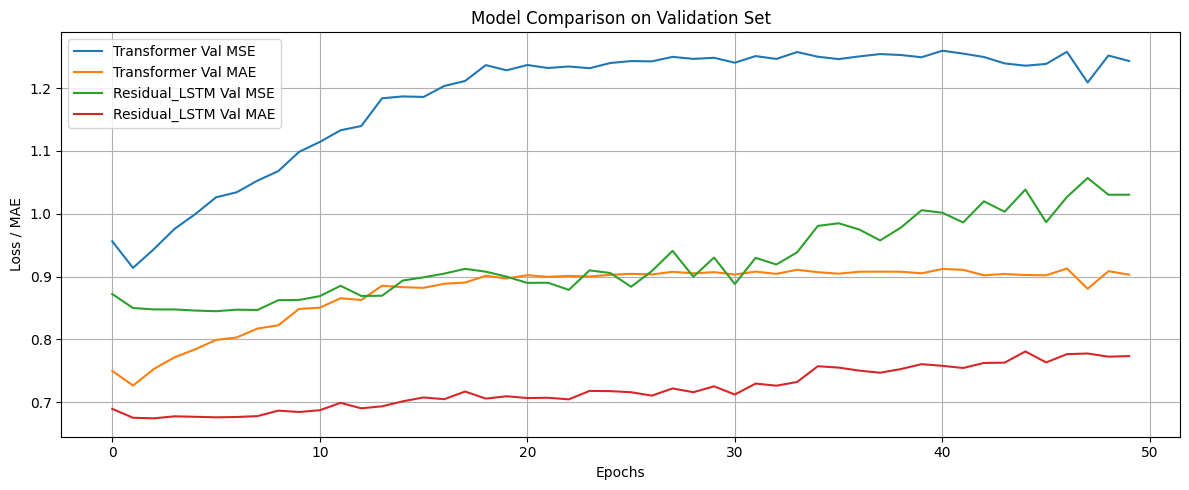

In [ ]:
# # NSE prediction using DDIM conditioned on NYSE returns

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, Model, Input
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import matplotlib.pyplot as plt

# # === Load Data ===
# nifty = pd.read_csv("NIFTY_50_5_Year_His_Data.csv")
# nyse = pd.read_csv("NYSE_5_Year_His_Data.csv")

# df_nifty = pd.DataFrame(nifty)
# df_nyse = pd.DataFrame(nyse)

# df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])
# df_nyse['Date'] = pd.to_datetime(df_nyse['Date'])

# df_nifty.set_index('Date', inplace=True)
# df_nyse.set_index('Date', inplace=True)

# common_dates = df_nifty.index.intersection(df_nyse.index)
# df_nifty_common = df_nifty.loc[common_dates]
# df_nyse_common = df_nyse.loc[common_dates]

# df_nifty_common['return'] = df_nifty_common['Close'].pct_change()
# df_nyse_common['return'] = df_nyse_common['Close'].pct_change()

# returns_nifty = df_nifty_common['return'].dropna()
# returns_nyse = df_nyse_common['return'].dropna()

# min_len = min(len(returns_nifty), len(returns_nyse))
# returns_nifty = returns_nifty[-min_len:]
# returns_nyse = returns_nyse[-min_len:]

# lookback = 30
# nse_lookback = 5
# x_data = []
# y_data = []
# for i in range(lookback, len(returns_nyse)):
#     x = np.concatenate([
#         returns_nyse.iloc[i - lookback:i].values,
#         returns_nifty.iloc[i - nse_lookback:i].values
#     ])
#     x_data.append(x)
#     y_data.append([returns_nifty.iloc[i]])

# x_data = np.array(x_data, dtype=np.float32)
# y_data = np.array(y_data, dtype=np.float32)

# split = int(0.8 * len(x_data))
# x_train, x_val = x_data[:split], x_data[split:]
# y_train, y_val = y_data[:split], y_data[split:]

# # === Hyperparameters ===
# T = 1000
# beta_start = 1e-4
# beta_end = 0.02
# embedding_dim = 32
# input_dim = lookback + nse_lookback

# betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
# alphas = 1.0 - betas
# alpha_bars_np = np.cumprod(alphas).astype(np.float32)
# alpha_bars = tf.convert_to_tensor(alpha_bars_np, dtype=tf.float32)

# def get_timestep_embedding(timesteps, dim):
#     half = dim // 2
#     emb = np.log(10000) / (half - 1)
#     emb = np.exp(np.arange(half) * -emb)
#     emb = timesteps[:, None] * emb[None, :]
#     emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
#     return tf.convert_to_tensor(emb, dtype=tf.float32)

# # === Transformer Encoder Block with Positional Encoding ===
# def get_transformer_denoise_model():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     cond_input = Input(shape=(input_dim,))

#     t_proj = layers.Dense(16, activation='relu')(t_input)
#     cond_proj = layers.Dense(64, activation='relu')(cond_input)

#     x = layers.Concatenate()([t_proj, cond_proj])
#     x = layers.Reshape((1, 80))(x)

#     attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
#     x = layers.Add()([x, attn_output])
#     x = layers.LayerNormalization()(x)

#     ffn = layers.Dense(64, activation='relu')(x)
#     ffn = layers.Dense(80)(ffn)
#     x = layers.Add()([x, ffn])
#     x = layers.LayerNormalization()(x)

#     x = layers.Flatten()(x)
#     x = layers.Concatenate()([x, y_t_input])
#     x = layers.Dense(64, activation='relu')(x)
#     out = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, cond_input], out)

# # === Residual LSTM Model ===
# def get_lstm_denoise_model():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     cond_input = Input(shape=(input_dim,))

#     cond_proj = layers.Reshape((input_dim, 1))(cond_input)
#     x = layers.LSTM(64)(cond_proj)
#     x = layers.Concatenate()([x, t_input, y_t_input])
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.Dense(64, activation='relu')(x)
#     out = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, cond_input], out)

# # === Forward and Sampling Functions Remain Same ===
# # (not repeated here for brevity — assumed unchanged)



# # === Data Preprocessing ===
# scaler_x = StandardScaler()
# scaler_y = StandardScaler()
# x_train_scaled = scaler_x.fit_transform(x_train)
# x_val_scaled = scaler_x.transform(x_val)
# y_train_scaled = scaler_y.fit_transform(y_train)
# y_val_scaled = scaler_y.transform(y_val)

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train_scaled)).batch(64).shuffle(1000)
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val_scaled, y_val_scaled)).batch(64)

# # === Split Conditioning Inputs ===
# def split_inputs(x_scaled):
#     cond_input = x_scaled[:, :input_dim]
#     n = x_scaled.shape[0]
#     timesteps = np.random.randint(0, T, size=n)
#     t_input = get_timestep_embedding(timesteps, embedding_dim).numpy()
#     y_t = np.zeros((n, 1), dtype=np.float32)
#     return [y_t, t_input, cond_input]

# train_inputs = split_inputs(x_train_scaled)
# val_inputs = split_inputs(x_val_scaled)

# train_dataset = tf.data.Dataset.from_tensor_slices(((train_inputs[0], train_inputs[1], train_inputs[2]), y_train_scaled)).batch(64).shuffle(1000)
# val_dataset = tf.data.Dataset.from_tensor_slices(((val_inputs[0], val_inputs[1], val_inputs[2]), y_val_scaled)).batch(64)


# # === Train Models and Compare ===
# models = {
#     'Transformer': get_transformer_denoise_model(),
#     'Residual_LSTM': get_lstm_denoise_model()
# }

# histories = {}
# for name, model in models.items():
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     print(f"\nTraining {name} model...")
#     history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, verbose=0)
#     histories[name] = history

# # === Plot Comparison ===
# plt.figure(figsize=(12, 5))
# for name, hist in histories.items():
#     plt.plot(hist.history['val_loss'], label=f'{name} Val MSE')
#     plt.plot(hist.history['val_mae'], label=f'{name} Val MAE')
# plt.title('Model Comparison on Validation Set')
# plt.xlabel('Epochs')
# plt.ylabel('Loss / MAE')
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()
